In [7]:
# from langchain.agents import initialize_agent, Tool
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from typing import Optional, TypedDict, Annotated
from pydantic.v1 import BaseModel, Field
import operator
# from langchain.prompts import PromptTemplate
import requests
from github import Github
import os
import getpass
from bandit.core import manager, config
from azure.identity import ManagedIdentityCredential
import config
import pandas as pd
import ollama
import tempfile


In [8]:
# === Config ===
REPO_NAME = "greenqloud/cloud-backup-service"
PULL_REQUEST_NUMBER = 1853

In [9]:
# def get_prometheus_rule_groups(subscription_id, resource_group=config.RESOURCEGROUP, client_id=config.PROMETHEUS_CLIENT_ID):
#     """
#     Fetch Prometheus rule groups from Azure Monitor and return as a DataFrame.

#     Args:
#         subscription_id (str): Azure subscription ID.
#         resource_group (str): Azure resource group name.
#         api_version (str): API version to use.
#         client_id (str): Client ID for Managed Identity.

#     Returns:
#         pd.DataFrame: DataFrame containing rule group details, or None if the request fails.
#     """
#     # Get token using Managed Identity (DefaultAzureCredential)
#     credential = ManagedIdentityCredential(client_id=client_id)
#     token = credential.get_token("https://management.azure.com/.default").token

#     # Construct API URL for listing all rule groups
#     url = (
#         f"https://management.azure.com/subscriptions/{subscription_id}"
#         f"/resourceGroups/{resource_group}/providers/Microsoft.AlertsManagement"
#         f"/prometheusRuleGroups?api-version=2023-03-01"
#     )

#     # Set headers with the bearer token
#     headers = {
#         "Authorization": f"Bearer {token}",
#         "Content-Type": "application/json"
#     }

#     # Make the GET request to Azure Monitor
#     response = requests.get(url, headers=headers)

#     # Check and process response
#     if response.status_code == 200:
#         data = response.json()
#         rule_groups = []
#         for rule_group in data.get("value", []):
#             rule_groups.append({
#                 "Name": rule_group['name'],
#                 "Location": rule_group.get('location'),
#                 "Description": rule_group.get('properties', {}).get('description'),
#                 "Rules": rule_group.get('properties', {}).get('rules')
#             })
#         return pd.DataFrame(rule_groups)
#     else:
#         print(f"Failed to fetch rule groups. Status Code: {response.status_code}")
#         print(response.text)
#         return None

In [10]:
# === Tool 1: GitHub PR Fetcher ===
def fetch_pr_diff_and_metadata(repo_name=REPO_NAME, pr_number=PULL_REQUEST_NUMBER, github_token=config.GITHUB_TOKEN):
    """
    Fetch pull request metadata and diff from GitHub.

    Args:
        repo_name (str): The full repository name (e.g., "owner/repo").
        pr_number (int): The pull request number.
        github_token (str): GitHub personal access token.

    Returns:
        dict: Dictionary with keys 'pr', 'pr_title', 'pr_body', 'diff_text'.
    """
    g = Github(github_token)
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    pr_title = pr.title
    pr_body = pr.body
    diff_response = requests.get(
        f"https://api.github.com/repos/{repo_name}/pulls/{pr_number}",
        headers={
            "Authorization": f"token {github_token}",
            "Accept": "application/vnd.github.v3.diff"
        }
    )
    diff_text = diff_response.text
    return diff_text
class prrepo(BaseModel):
    repo_name: str = Field(description="Repo to execute")
    pr_number: int = Field(description="PR number to execute")
@tool(args_schema = prrepo)
def fetchprdiff(repo_name: str, pr_number: int) -> str:
  """Returns the result of diff text in a PR"""
  return fetch_pr_diff_and_metadata(repo_name, pr_number, github_token=config.GITHUB_TOKEN)


# === Tool 1: GitHub File Fetcher ===
def get_file_context(filename, ref="master"):
    g = Github(config.GITHUB_TOKEN)
    repo = g.get_repo(REPO_NAME)
    try:
        contents = repo.get_contents(filename, ref=ref)
        return contents.decoded_content.decode('utf-8', errors='ignore')
    except Exception as e:
        return f"Error fetching file {filename}: {e}"
# Tool for langrgaph

class filecontent(BaseModel):
    filename: str = Field(description="Get full contents of file")
@tool(args_schema = filecontent)
def file_fetch_tool(filename: str, ref: str = "master") -> str:
   """
    Fetch full content of a given file from the repo for additional context.
    """
   return get_file_context(filename, ref="master")



# === Tool 2: Prometheus metrics fetcher ===
def get_prometheus_metrics(prometheus_url="https://prometheusmdmeastus-stage-060d.eastus.prometheus.monitor.azure.com"):
    try:
        credential = ManagedIdentityCredential(client_id=config.PROMETHEUS_CLIENT_ID)
        token = credential.get_token("https://data.monitor.azure.com").token
        headers = {
            "Authorization": f"Bearer {token}"
        }
        response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", headers=headers)
        response.raise_for_status()
        data = response.json()
        if data.get('status') == 'success':
            return data.get('data', [])
        else:
            print(f"Error from Prometheus API: {data}")
            return []
    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed: {e}")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
# Tool for LangGraph
class prometheusmetricsurl(BaseModel):
    prometheus_url: str = Field(description="Get full contents of file")
@tool(args_schema = prometheusmetricsurl)
def prometheus_metrics_fetch_tool(prometheus_url: str) -> list:
    """
    Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
    """
    return get_prometheus_metrics(prometheus_url)




# === Tool 3: Prometheus alerts rule groups fetcher ===
def get_prometheus_rule_groups(subscription_id, resource_group=config.RESOURCEGROUP, client_id=config.PROMETHEUS_CLIENT_ID):
    """
    Fetch Prometheus rule groups from Azure Monitor and return as a DataFrame.

    Args:
        subscription_id (str): Azure subscription ID.
        resource_group (str): Azure resource group name.
        api_version (str): API version to use.
        client_id (str): Client ID for Managed Identity.

    Returns:
        pd.DataFrame: DataFrame containing rule group details, or None if the request fails.
    """
    # Get token using Managed Identity (DefaultAzureCredential)
    credential = ManagedIdentityCredential(client_id=client_id)
    token = credential.get_token("https://management.azure.com/.default").token

    # Construct API URL for listing all rule groups
    url = (
        f"https://management.azure.com/subscriptions/{subscription_id}"
        f"/resourceGroups/{resource_group}/providers/Microsoft.AlertsManagement"
        f"/prometheusRuleGroups?api-version=2023-03-01"
    )

    # Set headers with the bearer token
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json"
    }

    # Make the GET request to Azure Monitor
    response = requests.get(url, headers=headers)

    # Check and process response
    if response.status_code == 200:
        data = response.json()
        rule_groups = []
        for rule_group in data.get("value", []):
            rule_groups.append({
                "Name": rule_group['name'],
                "Location": rule_group.get('location'),
                "Description": rule_group.get('properties', {}).get('description'),
                "Rules": rule_group.get('properties', {}).get('rules')
            })
        return pd.DataFrame(rule_groups)
    else:
        print(f"Failed to fetch rule groups. Status Code: {response.status_code}")
        print(response.text)
        return None
# Tool for LangGraph
class prometheusmetricsurla(BaseModel):
    subscription_id: str = Field(description="subscription id")
@tool(args_schema = prometheusmetricsurla)
def prometheus_alert_rule_group_fetch_tool(subscription_id: str) -> list:
    """
    Fetch all the prometheus metrics from azure monitor workspace to get context for observability.
    """
    return get_prometheus_rule_groups(subscription_id)

# # === Tool 4: Bandit Code Security checker ===
# def check_code_security(file_path):
#     """
#     Check a Python file for security vulnerabilities using Bandit.

#     :param file_path: Path to the Python file to analyze
#     :return: Bandit report as a string
#     """
#     # Load Bandit configuration
#     bandit_config = config.BanditConfig()

#     # Initialize Bandit manager
#     bandit_manager = manager.BanditManager(bandit_config, "file", False)

#     # Run Bandit on the specified file
#     bandit_manager.discover_files([file_path])
#     bandit_manager.run_tests()

#     # Generate and return the report
#     issues = bandit_manager.get_issue_list()
#     if not issues:
#         return "No high-level vulnerabilities found. Checking for lower-level issues..."

#     # If no high-level issues, check for lower-level issues
#     lower_level_issues = []
#     for issue in issues:
#         if issue.severity.lower() in ['low', 'medium']:
#             lower_level_issues.append(str(issue))

#     if lower_level_issues:
#         return "\n".join(lower_level_issues)
#     else:
#         return "No vulnerabilities found, including lower-level issues."
# # Tool wrapper for LangChain
# class banditsecurity(BaseModel):
#     file_path: str = Field(description="Get path of file to execute")
# @tool(args_schema = banditsecurity)
# def bandit_security_checker_tool(file_path: str) -> str:
#     """
#     Check security of a python code using bandit library.
#     """
#     return check_code_security(file_path)



# === Tool 4: Bandit Code Security checker for PR files ===
def check_pr_files_security(repo_name, pr_number):
    """
    Fetch changed files in a PR, get their content, and check for security vulnerabilities using Bandit.

    :param repo_name: Repository name (e.g., "owner/repo")
    :param pr_number: Pull request number
    :return: Bandit report as a string
    """
    g = Github(config.GITHUB_TOKEN)
    repo = g.get_repo(repo_name)
    pr = repo.get_pull(pr_number)
    changed_files = [f.filename for f in pr.get_files() if f.filename.endswith('.py')]
    if not changed_files:
        return "No Python files changed in this PR."

    results = []
    for filename in changed_files:
        code = get_file_context(filename, ref=pr.head.ref)
        # Write code to a temporary file for Bandit to scan
        with tempfile.NamedTemporaryFile(mode='w+', suffix='.py', delete=False) as tmp:
            tmp.write(code)
            tmp_path = tmp.name
        # Run Bandit
        bandit_config = config.BanditConfig()
        bandit_manager = manager.BanditManager(bandit_config, "file", False)
        bandit_manager.discover_files([tmp_path])
        bandit_manager.run_tests()
        issues = bandit_manager.get_issue_list()
        if not issues:
            results.append(f"{filename}: No high-level vulnerabilities found.")
        else:
            lower_level_issues = []
            for issue in issues:
                if issue.severity.lower() in ['low', 'medium']:
                    lower_level_issues.append(str(issue))
            if lower_level_issues:
                results.append(f"{filename}:\n" + "\n".join(lower_level_issues))
            else:
                results.append(f"{filename}: No vulnerabilities found, including lower-level issues.")
    return "\n\n".join(results)

class banditprsecurity(BaseModel):
    repo_name: str = Field(description="Repo to execute")
    pr_number: int = Field(description="PR number to execute")
@tool(args_schema = banditprsecurity)
def bandit_pr_security_checker_tool(repo_name: str, pr_number: int) -> str:
    """
    Check security of all Python files changed in a PR using the bandit library.
    """
    return check_pr_files_security(repo_name, pr_number)

In [11]:
from semantic_router.utils.function_call import FunctionSchema
# create the function calling schema for ollama
execute_query_schema = FunctionSchema(fetch_pr_diff_and_metadata).to_ollama()
# execute_query_schema["function"]["parameters"]["properties"]["description"] = None
execute_query_schema["function"]["parameters"]["properties"]["description"] = None
execute_query_schema

2025-05-28 06:09:20 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


{'type': 'function',
 'function': {'name': 'fetch_pr_diff_and_metadata',
  'description': 'Fetch pull request metadata and diff from GitHub.\n\nArgs:\n    repo_name (str): The full repository name (e.g., "owner/repo").\n    pr_number (int): The pull request number.\n    github_token (str): GitHub personal access token.\n\nReturns:\n    dict: Dictionary with keys \'pr\', \'pr_title\', \'pr_body\', \'diff_text\'.',
  'parameters': {'type': 'object',
   'properties': {'repo_name': {'description': None, 'type': 'object'},
    'pr_number': {'description': None, 'type': 'object'},
    'github_token': {'description': None, 'type': 'object'},
    'description': None},
   'required': ['repo_name', 'pr_number', 'github_token']}}}

In [12]:
# Define the agent state
class AgentState(TypedDict):
   messages: Annotated[list[AnyMessage], operator.add]

In [13]:
class PRRAgent:
  # initialising the object
  def __init__(self, model, tools, system_prompt = ""):
    self.system_prompt = system_prompt

    # initialising graph with a state 
    graph = StateGraph(AgentState)

    # adding nodes 
    graph.add_node("llm", self.call_llm)
    graph.add_node("function", self.execute_function)
    graph.add_conditional_edges(
      "llm",
      self.exists_function_calling,
      {True: "function", False: END}
    )
    graph.add_edge("function", "llm")

    # setting starting point
    graph.set_entry_point("llm")

    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}
    self.model = model.bind_tools(tools)

    from IPython.display import Image, display

    try:
      display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception:
      # This requires some extra dependencies and is optional
      pass

  def call_llm(self, state: AgentState):
    messages = state['messages']
    # adding system prompt if it's defined
    if self.system_prompt:
        messages = [SystemMessage(content=self.system_prompt)] + messages

    # calling LLM
    message = self.model.invoke(messages)

    return {'messages': [message]}
  
  def execute_function(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls

    results = []
    for tool in tool_calls:
      # checking whether tool name is correct
      if not tool['name'] in self.tools:
        # returning error to the agent 
        result = "Error: There's no such tool, please, try again" 
      else:
        # getting result from the tool
        result = self.tools[tool['name']].invoke(tool['args'])

      results.append(
        ToolMessage(
          tool_call_id=tool['id'], 
          name=tool['name'], 
          content=str(result)
        )
    )
    return {'messages': results}
  
  def exists_function_calling(self, state: AgentState):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

In [14]:
prompt = '''You are a senior AI engineer agent. you would wear multiple hats in the fields of observability and security
TASK:
Analyze the given pull request diff for potential observability and security issues.
Use fetchprdiff tool to fetch the diff on a pull request
Use a checklist for each area:
For observability:
- Are there actionable alerts identified for the feature? Are there Runbooks for the actionable alerts? Do we have TSGs attached to the alert? use prometheus_alert_rule_group_fetch_tool to see if there are already alert rules related to this change
- Are there metrics to monitor dependencies and exception handling on components, infrastructure and features so that SRE can create alerts to reduce TTD? Use prometheus_metrics_fetch_tool to see if there are metrics related to the change 
- Are there CorrelationIDs established in logs to derive error lineage across various components?
- Can the feature/service support changing log levels for troubleshooting purposes?
- Are there critical log lines that we need to get alerted upon?
For Security 
- All sensitive log lines are masked appropriately?
- Are all secrets encrypted at rest and in transit?
- Are all data encrypted at rest and in transit?
- Are we using distroless/mariner base image/s?
If the diff is unclear, use the FileFetcher tool to retrieve extra context of the file.
If the file has import from custom modules use the file_fetch_tool tool to retreive the file
Tell me if you fetched files for additional context
Begin step-by-step reasoning.
First, summarize what the change is doing.
Then, identify observability gaps and risky areas.
Finally, provide a observability and security risk report.
Structure your response in a markdown format and add a table with the following columns:
| Area | Gap | Risk Level | Recommendation |
'''

In [18]:
from langchain_ollama import ChatOllama
# qwen3:32b            e1c9f234c6eb    20 GB    About a minute ago very good
# gemma3:27b           a418f5838eaf    17 GB    5 minutes ago doesn't support tools
# qwen2.5-coder:32b    4bd6cbf2d094    19 GB    6 minutes ago
# devstral:latest      c4b2fa0c33d7    14 GB    8 minutes ago
# llama3.3:latest      a6eb4748fd29    42 GB    2 days ago not bad but often fails tool calling
# granite-code:34b
modelname =  "llama3.3:latest" 
model = ChatOllama(model=modelname, temperature=0.1)




In [20]:
tools = [fetchprdiff,
        file_fetch_tool,
        prometheus_metrics_fetch_tool,
        prometheus_alert_rule_group_fetch_tool,
        bandit_pr_security_checker_tool
        ]
# Instantiate the agent
agent_instance = PRRAgent(model, tools, prompt)

# Prepare the input messages
human_message = f"Analyze the pull request {PULL_REQUEST_NUMBER} from {REPO_NAME}"
messages = [HumanMessage(content=human_message)]

# Invoke the agent's graph and get the result
result = agent_instance.graph.invoke({"messages": messages})

# Print the agent's thought process and tool usage
for msg in result['messages']:
    if hasattr(msg, 'content') and msg.content:
        print(f"{msg.__class__.__name__}: {msg.content}\n")

# Display the agent's response
result['messages'][-1].content

2025-05-28 06:17:24 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-05-28 06:17:51 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


HumanMessage: Analyze the pull request 1853 from greenqloud/cloud-backup-service

ToolMessage: diff --git a/api_service/server/database/database.go b/api_service/server/database/database.go
index bc34add74..145ec0ed3 100644
--- a/api_service/server/database/database.go
+++ b/api_service/server/database/database.go
@@ -35,6 +35,7 @@ const (
 	DEFAULTLIMIT               = 100
 	// MariaDBInReadOnlyModeError Expected substring for error incurred due to maria db being in read-only mode
 	MariaDBInReadOnlyModeError = "Error 1290: The MariaDB server is running with the --read-only"
+	GSProcessingError          = "GS is processing baseline backup"
 )
 
 // The '_' and '%' are wildcards in a LIKE operated statement in SQL.
@@ -174,15 +175,16 @@ func (sqlDb *SqlDatabase) CreateJobIfNotInProgress(jobType, fileSystemID, json s
 	LIMIT 1`
 	*/
 	jobExists := false
-	var row int
+
+	var job_type, errMsg string
 	exclusiveJobTypes := fmt.Sprintf("'%s','%s'", util.RestoreJobType, util.DeleteQuarkObje

'## Summary of the Change\nThe pull request 1853 from greenqloud/cloud-backup-service modifies the `CreateJobIfNotInProgress` function in the `database.go` file to handle a new error case when a baseline backup is in progress. The change adds a check for the `GSProcessingError` error message and returns a `DuplicateEntryError` with a specific error message if the job exists and the error message matches.\n\n## Observability Gaps and Risky Areas\nThe following observability gaps and risky areas were identified:\n\n* There are no actionable alerts defined for the new error case introduced by this change.\n* There are no metrics to monitor dependencies and exception handling on components, infrastructure, and features related to this change.\n* CorrelationIDs are not established in logs to derive error lineage across various components.\n* The feature/service does not support changing log levels for troubleshooting purposes.\n* Critical log lines that require alerts are not defined.\n\n##

In [21]:
# Display the agent's response
result['messages'][-1].content

'## Summary of the Change\nThe pull request 1853 from greenqloud/cloud-backup-service modifies the `CreateJobIfNotInProgress` function in the `database.go` file to handle a new error case when a baseline backup is in progress. The change adds a check for the `GSProcessingError` error message and returns a `DuplicateEntryError` with a specific error message if the job exists and the error message matches.\n\n## Observability Gaps and Risky Areas\nThe following observability gaps and risky areas were identified:\n\n* There are no actionable alerts defined for the new error case introduced by this change.\n* There are no metrics to monitor dependencies and exception handling on components, infrastructure, and features related to this change.\n* CorrelationIDs are not established in logs to derive error lineage across various components.\n* The feature/service does not support changing log levels for troubleshooting purposes.\n* Critical log lines that require alerts are not defined.\n\n##

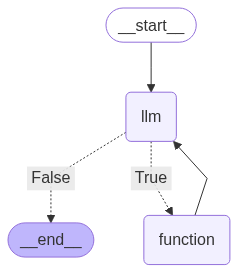

In [22]:
from IPython.display import Image, display

# Visualize the compiled agent graph
display(Image(agent_instance.graph.get_graph().draw_mermaid_png()))